In [1]:
%load_ext autoreload
%autoreload 2   
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
from qscope.device.seqgen.sequence_plotting import *
import qscope.device.seqgen.pulseblaster.spinapi as pb

# Test pulse blaster connection

In [ ]:
pb.pb_select_board(0)
pb.pb_init()
pb.pb_core_clock(500)

# Simple testing

In [ ]:
# define a list of chs to be used in the code
ch_defs = {
    "laser": "00000001",
    "rf_x": "00000010",
    "rf_-x": "00000100",
    "rf_y": "00001000",
    "rf_-y": "00010000",
    "rf_trig": "00100000",
    "camera": "01000000",
    "rf2_trig": "10000000",
}
# Define the delays that we need to use in the sequence
laser_dur = 1e-6
rf_dur = 1e-6
laser_delay = 500e-9
rf_delay = 250e-9
laser_to_rf_delay = 200e-9
rf_to_laser_delay = 50e-9


In [ ]:
# Make a basic list of states for a pulsed odmr sequence
# This is the traditional approach to defining a sequence

# make a list of dictionaries that define the instructions
insts = []

insts.append({"active_chs": ["laser"], "dur": laser_dur, "ch_delay": laser_delay, "const_chs": ["camera"]})
insts.append({"active_chs": [ ], "dur": laser_to_rf_delay, "ch_delay": 0, "const_chs": ["camera"]})
insts.append({"active_chs": ["rf_x",], "dur": rf_dur, "ch_delay": rf_delay, "const_chs": ["camera"]})
insts.append({"active_chs": [], "dur": rf_to_laser_delay, "ch_delay": 0, "const_chs": ["camera"]})

# plot_instructions_kernel(insts, ch_defs)


In [ ]:
# Define the kernal using a pulse series object

from qscope.device.seqgen.pulse_kernel import PulseKernel

pk = PulseKernel(ch_defs)

pk.add_pulse(["laser"], 0, 100e-9, ch_delay=laser_delay)
pk.add_pulse(["laser"], 300e-9, 100e-9, ch_delay=laser_delay)
pk.add_pulse(["laser"], 2e-6, laser_dur, ch_delay=laser_delay)

pk.append_delay(laser_to_rf_delay)
pk.append_pulse(["rf_x"],  rf_dur, ch_delay=rf_delay)
pk.add_pulse(["rf_-x"],  100e-9, rf_dur, ch_delay=rf_delay)
pk.add_pulse(["rf_-y"],  0, 0.2*rf_dur, ch_delay=rf_delay)

pk.append_delay(1000e-9, var_dur=False)
pk.append_pulse(["rf_y"] , rf_dur, ch_delay=rf_delay)
pk.append_pulse(["rf_trig"],  rf_dur*0.5, ch_delay=rf_delay)

# pk.print_pulses()

pk.plot_pulses()



In [ ]:
pk.shift_ch_delays()
# pk.print_pulses()
pk.plot_pulses()

In [ ]:
pk.wrap_pulses()
pk.plot_pulses()


In [ ]:
# Convert to instructions and plot the kernel
pk.convert_to_instructions(const_chs=["camera"])
pk.plot_inst_kernel()


# Variable kernel def and plotting

In [ ]:
# Define the kernal using a pulse series object

from qscope.device.seqgen.pulse_kernel import PulseKernel

pk = PulseKernel(ch_defs)

rf_delay = 500e-9

pk.add_pulse(["laser"], 0, laser_dur, ch_delay=laser_delay)
pk.append_delay(laser_to_rf_delay)
pk.append_pulse(["rf_x"],  rf_dur, ch_delay=rf_delay)
pk.append_delay(120e-9, var_dur=True)
pk.append_pulse(["rf_y"] , rf_dur, ch_delay=rf_delay)
pk.append_pulse(["rf_trig"],  rf_dur*0.5, ch_delay=0)
pk.finish_kernel()

print(pk.kernel["rf_y"])
print(pk.kernel_unaltered["rf_y"])


In [ ]:
# Define the variable delays and plot the kernel
t = np.linspace(12e-9, 5e-6, 10)

idx = 5

pk.update_var_durs(t[idx])

# pk.plot_pulses()
pk.convert_to_instructions()

pk.plot_inst_kernel()


In [ ]:
# Define the kernal using a pulse series object
from qscope.device.seqgen.pulse_kernel import PulseKernel
# Create the SIGNAL kernel
pk_sig = PulseKernel(ch_defs)
# Program the kernel pulses
pk_sig.add_pulse(["laser"], 0, 1000, ch_delay=0)
pk_sig.append_delay(200)
pk_sig.append_pulse(["rf_x"], 100, ch_delay=0)
pk_sig.finish_kernel()
pk_sig_cam = pk_sig.convert_to_instructions(const_chs=["camera"])
# pk_sig.plot_pulses()

pk_sig.convert_to_instructions()

pk_sig_cam.insts

# pk_sig.plot_inst_kernel()

# Example of pulsed ODMR full sequence

In [ ]:
class dummy_pb():
    def __init__(self):
        self.insts = []
    def add_instruction(self, active_chs = None, dur = 0, *args, **kwargs):
        # self.insts.append(inst)
        return
    def get_instructions(self):
        return self.insts
    def start_programming(self):
        pass
    def end_sequence(self, *args, **kwargs):
        pass
    def stop_programming(self):
        pass

    def add_kernel(self, pulse_kernel, num_loop, const_chs=[]):
        ''' 
        Add the instructions to the signal generator assuming that the instructions that have been defined is a kernel
        '''
        pass
        pulse_kernel.convert_to_instructions(const_chs=const_chs)
        # add the instructions to the pulseblaster in a loop
        for inst in self.insts:
            # For the first instruction, we need to add the start loop instruction
            if self.insts.index(inst) == 0:
                loop_inst = self.add_instruction(loop="start", num_loop=num_loop, **inst)
            # For the last instruction, we need to add the end loop instruction
            elif self.insts.index(inst) == len(self.insts) - 1:
                self.add_instruction(loop="end", inst=loop_inst, **inst)
            else:
                self.add_instruction(**inst)
        return

In [ ]:
seqgen = dummy_pb()

avg_per_point = 2
int_time = 100e-6
num_loops = 1e3
tau = 100e-9
trig_time = 10e-6
trig_loops = 1e2


# --- SIGNAL KERNEL ---
# initialise the pulse series object
pk_sig = PulseKernel(ch_defs)
# Program the kernel pulses
pk_sig.add_pulse(["laser"], 0, laser_dur, ch_delay=laser_delay)
pk_sig.append_delay(laser_to_rf_delay)
pk_sig.append_pulse(["rf_x"], rf_dur, ch_delay=rf_delay)

# --- REFERENCE KERNEL ---
# Program the kernel pulses
pk_ref = PulseKernel(ch_defs)
# Program the kernel pulses
pk_ref.add_pulse(["laser"], 0, laser_dur, ch_delay=laser_delay)
pk_ref.append_delay(laser_to_rf_delay)
pk_ref.append_delay(rf_dur)

# --- PROGRAMMING ---
seqgen.start_programming()
# Initial laser pulse
seqgen.add_instruction(**{"active_chs": ["laser"], "dur": laser_dur})

# Start the per point average loop if required 
if avg_per_point > 1:
    inst = seqgen.add_instruction([], 
                                  12e-9,
                                  loop="start", 
                                  num=avg_per_point, 
                                  const_chs=["camera"])
    
# Add the SIG kernel to the sequence generator
seqgen.add_kernel(pk_sig, num_loops, const_chs=["camera"])
seqgen.add_kernel(pk_sig, trig_loops, const_chs=["rf_trig"])
 # Add the REF kernel to the sequence generator
seqgen.add_kernel(pk_ref, num_loops, const_chs=["camera"])
seqgen.add_kernel(pk_ref, trig_loops, const_chs=["rf_trig"])

if avg_per_point > 1:
    seqgen.add_instruction([], 12e-9, loop="end", inst=inst)

seqgen.add_instruction([], trig_time)
seqgen.end_sequence(10e6)
seqgen.stop_programming()


# Test actual sequence 

Used for running sequences with the pulseblaster to check them on an oscilloscope. 

In [4]:
from qscope.device.seqgen.pulseblaster import PulseBlaster
import numpy as np
from qscope.device.seqgen.pulseblaster.seq_cw_esr import seq_cw_esr
from qscope.device.seqgen.pulseblaster.seq_p_esr import seq_p_esr
from qscope.device.seqgen.pulseblaster.seq_rabi import seq_rabi
ch_defs = {
    "laser": "00000001",
    "rf_x": "00000010",
    "rf_-x": "00000100",
    "rf_y": "00001000",
    "rf_-y": "00010000",
    "rf_trig": "00100000",
    "camera": "01000000",
    "rf2_trig": "10000000",
}

sequence_params =  {
                    "laser_delay": 340e-9,
                    "rf_delay": 12e-9,
                    "camera_trig_time": 10e-3,
}                   

seqgen_pb = PulseBlaster(board_num="0", ch_defs=ch_defs, sequence_params=sequence_params)
seqgen_pb.open()

2024-12-11 10:30:04.511 | INFO     | qscope.device.seqgen.pulseblaster.spinapi:_checkloaded:77 - Using SpinAPI version b'20171214'
2024-12-11 10:30:04.532 | INFO     | qscope.device.seqgen.pulseblaster.pulseblaster:open:66 - Pulseblaster opened, status: {'stopped': False, 'reset': True, 'running': False, 'waiting': False}


(True, 'Pulseblaster opened')

In [108]:
sweep_x = np.linspace(20, 500, 51)*1e-9

# Program the pulse sequence
pk_sig, pk_ref = seq_rabi(
    seqgen= seqgen_pb,
    sequence_params=sequence_params,
    sweep_x=sweep_x,
    ref_mode = "no_rf",
    exp_t = 30e-3,
    laser_dur=1e-6,
    laser_delay=300e-9,
    # laser_to_rf_delay=200e-9,
    rf_dur=1e-9,
    rf_delay=50e-9,
    sweep_len = 21,
    avg_per_point = 1,
    camera_trig_time = 1e-3,
)
        
# seqgen_pb.is_connected()

2024-12-11 11:07:42.164 | INFO     | qscope.device.seqgen.pulseblaster.seq_rabi:seq_rabi:34 - Setting up Rabi sequence with no_rf as a reference
2024-12-11 11:07:42.164 | INFO     | qscope.device.seqgen.pulseblaster.seq_rabi:seq_rabi:86 - Programming Ramsey sequence with the following parameters:
Laser duration: 1000 ns
First RF pulse duration: 20 ns
Last RF pulse duration: 500 ns
Laser delay: 300 ns
RF delay: 50 ns
Reference mode: no_rf
Base time: 1200 ns
Camera exposure time: 30.0 ms
Number of loops: 27500
Camera trigger time: 1.0 ms
Number of trigger loops: 916
2024-12-11 11:07:42.164 | INFO     | qscope.device.seqgen.pulseblaster.seq_rabi:seq_rabi:120 - 
tau: 20 ns
Base time: 1232 ns
2024-12-11 11:07:42.164 | INFO     | qscope.device.seqgen.pulseblaster.seq_rabi:seq_rabi:120 - 
tau: 29 ns
Base time: 1241 ns
2024-12-11 11:07:42.173 | INFO     | qscope.device.seqgen.pulseblaster.seq_rabi:seq_rabi:120 - 
tau: 39 ns
Base time: 1251 ns
2024-12-11 11:07:42.177 | INFO     | qscope.device.

In [109]:
pk_sig.reset_kernel()
pk_sig.update_var_durs(20-9)
pk_sig.convert_to_instructions()
pk_sig.insts

[{'active_chs': ['laser'], 'dur': 1000, 'const_chs': []},
 {'active_chs': [], 'dur': np.int64(450), 'const_chs': []},
 {'active_chs': ['rf_x'], 'dur': np.int64(11), 'const_chs': []},
 {'active_chs': [], 'dur': np.int64(62), 'const_chs': []}]

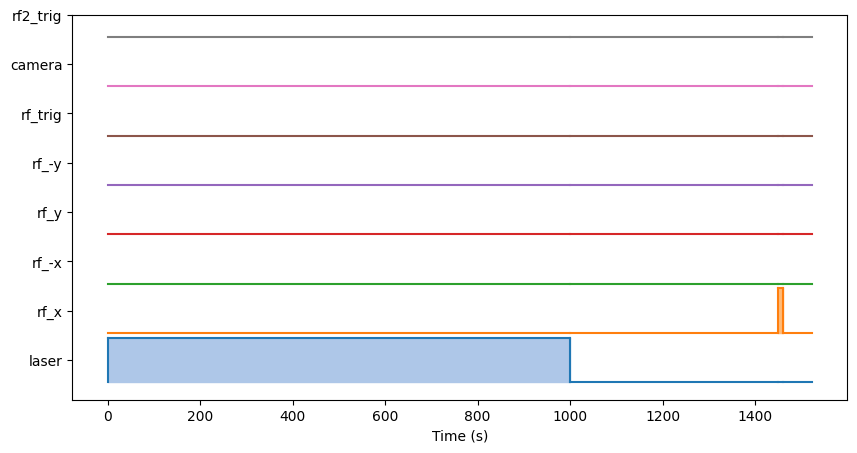

In [110]:
pk_sig.plot_inst_kernel()

In [85]:
seqgen_pb.start()


In [86]:
seqgen_pb.stop()

In [ ]:
seqgen_pb.close()

# Example of a rabi sequence with varying rf time

Used to test programming sequences. 


In [ ]:
seqgen = dummy_pb()

avg_per_point = 2
int_time = 100e-6
num_loops = 1e3
tau = 100e-9
trig_time = 10e-6
trig_loops = 1e2


# --- SIGNAL KERNEL ---
# initialise the pulse series object
pk_sig = PulseKernel(ch_defs)
# Program the kernel pulses
pk_sig.add_pulse(["laser"], 0, laser_dur, ch_delay=laser_delay)
pk_sig.append_delay(laser_to_rf_delay)
pk_sig.append_pulse(["rf_x"], rf_dur, ch_delay=rf_delay, var_dur=True)

# --- REFERENCE KERNEL ---
# Program the kernel pulses
pk_ref = PulseKernel(ch_defs)
# Program the kernel pulses
pk_ref.add_pulse(["laser"], 0, laser_dur, ch_delay=laser_delay)
pk_ref.append_delay(laser_to_rf_delay)
pk_ref.append_delay(rf_dur, var_dur=True)

# --- PROGRAMMING ---
seqgen.start_programming()
# Initial laser pulse
seqgen.add_instruction(**{"active_chs": ["laser"], "dur": laser_dur})

time_list = np.linspace(12e-9, 5e-6, 10)

for t in time_list:
    # Start the per point average loop if required 
    if avg_per_point > 1:
        inst = seqgen.add_instruction([], 
                                    12e-9, 
                                    loop="start", 
                                    num=avg_per_point, 
                                    const_chs=["camera"])
    # update the time in the kernel
    pk_sig.update_var_durs(t)

    # Add the SIG kernel to the sequence generator
    seqgen.add_kernel(pk_sig, num_loops, const_chs=["camera"])
    seqgen.add_kernel(pk_sig, trig_loops, const_chs=["rf_trig"])

    # update the time in the kernel
    pk_ref.update_var_durs(t)
    # Add the REF kernel to the sequence generator
    seqgen.add_kernel(pk_ref, num_loops, const_chs=["camera"])
    seqgen.add_kernel(pk_ref, trig_loops, const_chs=["rf_trig"])

    if avg_per_point > 1:
        seqgen.add_instruction([], 12e-9, loop="end", inst=inst)

seqgen.add_instruction([], trig_time)
seqgen.end_sequence(10e6)
seqgen.stop_programming()